# 主要关注subword level的文本数据预处理

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.6.3
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.3
keras.api._v2.keras 2.6.0


In [3]:
# 在这个库中，tf帮我们定义很多数据集，这些数据集是以dataset来存储的
# https://tensorflow.google.cn/datasets/catalog/overview
import tensorflow_datasets as tfds

# 仍然是电影的二分类问题
# 我们可以到数据集中去看imdb_reviews/subwords8k的信息
# with_info if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) 
# containing the info associated with the builder.
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info = True,
                          # as_supervised代表有监督的，会把labels，也就是结果返回
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

In [5]:
# 通过encoder把我们的词语转换为subword形式，vocab_size就是字典大小
tokenizer = info.features['text'].encoder
print('vocabulary size: {}'.format(tokenizer.vocab_size))

vocabulary size: 8185


In [6]:
type(tokenizer)

tensorflow_datasets.core.deprecated.text.subword_text_encoder.SubwordTextEncoder

In [7]:
for i in train_dataset.take(1):
    print(np.array(i[0]))
    print(len(i[0]))
    print(tokenizer.decode(np.array(i[0])))

[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
163
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in h

2022-05-19 15:03:15.130949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-19 15:03:15.183581: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
# 简单例子，加以理解
# subword level不可以去除标点符号
sample_string = 'Tensorflow is cool.'
# encode是变为id序列
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))
print(type(tokenized_string))
# decode又变为原来的字符串
original_string = tokenizer.decode(tokenized_string)
print('Original string is {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 2934, 7961, 9, 2724, 7975]
<class 'list'>
Original string is Tensorflow is cool.


In [9]:
# for循环看下每个id
for token in tokenized_string:
    print('{} --> {}--{}'.format(token, tokenizer.decode([token]),len(tokenizer.decode([token]))))

6307 --> Ten--3
2327 --> sor--3
2934 --> flow--4
7961 -->  --1
9 --> is --3
2724 --> cool--4
7975 --> .--1


In [10]:
buffer_size = 10000
batch_size = 64

#下面的代码是2.0版本的，已废弃
# print(train_dataset.output_shapes)
# print(test_dataset.output_shapes)

# train_dataset = train_dataset.shuffle(buffer_size)
# train_dataset = train_dataset.padded_batch(batch_size, train_dataset.output_shapes)
# test_dataset = test_dataset.padded_batch(batch_size, test_dataset.output_shapes)

padded_shapes=tf.compat.v1.data.get_output_shapes(train_dataset)

padded_shapes_test=tf.compat.v1.data.get_output_shapes(test_dataset)

print(train_dataset)

print(test_dataset)
# 自动填充到最大大小
train_dataset = train_dataset.shuffle(buffer_size)  # 做dataset洗牌

# padded_batch是每批数据分别做padding
train_dataset = train_dataset.padded_batch(batch_size,padded_shapes) 
test_dataset = test_dataset.padded_batch(batch_size,padded_shapes_test)

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>
<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


In [11]:
for i in train_dataset.take(1):
    print(np.array(i[0]))

[[2781 5805   64 ...    0    0    0]
 [6170    4 4221 ...    0    0    0]
 [ 338  109 7968 ...    0    0    0]
 ...
 [2415 7961 1572 ...    0    0    0]
 [  12   18 6884 ...    0    0    0]
 [ 519 1212    4 ...    0    0    0]]


2022-05-19 15:03:16.061929: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
vocab_size = tokenizer.vocab_size
embedding_dim = 16

bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
_________________________________________________________________


In [13]:
bi_rnn_model.variables

[<tf.Variable 'embedding/embeddings:0' shape=(8185, 16) dtype=float32, numpy=
 array([[ 0.00548359,  0.04233916, -0.04126672, ..., -0.02209276,
          0.0481217 ,  0.04053885],
        [ 0.00106363, -0.00307373,  0.04714259, ...,  0.03656591,
         -0.03638568,  0.02336559],
        [-0.00065539,  0.00642849,  0.03044965, ...,  0.00565688,
         -0.02393336, -0.03250259],
        ...,
        [-0.0334749 , -0.03983812, -0.04671034, ...,  0.03511424,
         -0.00648256, -0.03675542],
        [ 0.02980835,  0.04749595,  0.00690528, ...,  0.00218235,
         -0.04906626, -0.04870468],
        [-0.04753741,  0.00896207, -0.01004992, ...,  0.03300411,
         -0.0415054 , -0.03923965]], dtype=float32)>,
 <tf.Variable 'bidirectional/forward_lstm/lstm_cell_1/kernel:0' shape=(16, 128) dtype=float32, numpy=
 array([[-0.06024677, -0.10873422, -0.02101523, ..., -0.03985603,
         -0.06555302,  0.14096028],
        [ 0.10700649,  0.02328779,  0.1780718 , ..., -0.14771137,
         

In [14]:
8185*16

130960

In [15]:
history = bi_rnn_model.fit(
    train_dataset,
    # 因为之前30次过拟合，这里改为10次
    epochs = 10,
    validation_data = test_dataset)

Epoch 1/10


2022-05-19 15:03:21.043365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 57s 132ms/step - loss: 0.5316 - accuracy: 0.7210 - val_loss: 0.4093 - val_accuracy: 0.8332
Epoch 2/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3441 - accuracy: 0.8596 - val_loss: 0.4446 - val_accuracy: 0.8033
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.2692 - accuracy: 0.8984 - val_loss: 0.3745 - val_accuracy: 0.8456
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.2238 - accuracy: 0.9200 - val_loss: 0.3956 - val_accuracy: 0.8504
Epoch 5/10
391/391 [==============================] - 50s 126ms/step - loss: 0.1890 - accuracy: 0.9334 - val_loss: 0.4043 - val_accuracy: 0.8473
Epoch 6/10
391/391 [==============================] - 49s 124ms/step - loss: 0.2070 - accuracy: 0.9191 - val_loss: 0.5781 - val_accuracy: 0.6889
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.2456 - accuracy: 0.9058 - val_loss: 0.4488 - val_accuracy: 0.8

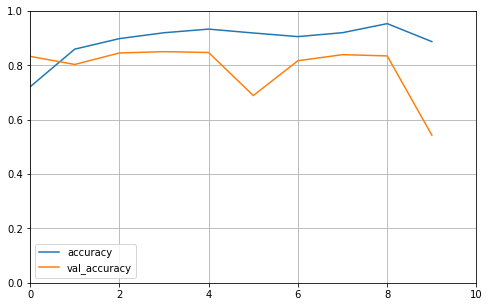

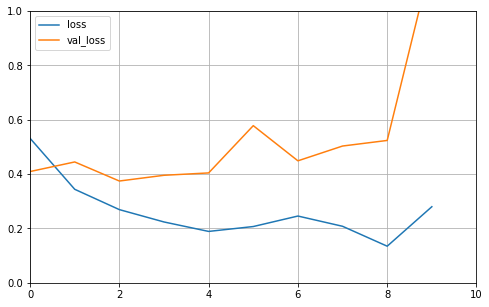

In [16]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', 10, 0, 1)
plot_learning_curves(history, 'loss', 10, 0, 1)
# 过拟合现象相对之前弱一些

In [17]:
bi_rnn_model.evaluate(test_dataset)

391/391 [==============================] - 14s 35ms/step - loss: 1.1914 - accuracy: 0.5433


[1.1914118528366089, 0.5433200001716614]